# SYS 611: Baseball Salary Model

Paul T. Grogan <pgrogan@stevens.edu>

This example performs maximum likelihood estimation to model the distribution of professional baseball player salaries.

## Dependencies

This example is compatible with Python 2 environments through use of the `__future__` library function. Additionally, this example uses the `numpy`, `pandas`, `scipy`, and `matplotlib.pyplot` libraries.

In [1]:
# import the python3 behavior for importing, division, and printing in python2
from __future__ import absolute_import, division, print_function

# import the numpy package and refer to it as `np`
import numpy as np

# import the pandas package and refer to it as `pd`
import pandas as pd

# import the stats and optimize libraries from the scipy package
from scipy import stats, optimize

# import the matplotlib.pyplot package and refer to it as `plt`
import matplotlib.pyplot as plt

## Load Data

Load the data (extracted from [Sean Lahman's Baseball Database](http://www.seanlahman.com/baseball-archive/statistics/)) from the CSV file. It contains a table of 853 records of professional baseball salaries from the 2016 season.

In [2]:
df = pd.read_csv('salaries.csv')
display(df)

,yearID,teamID,lgID,playerID,salary
0,2016,ARI,NL,ahmedni01,521600
1,2016,ARI,NL,barreja01,507500
2,2016,ARI,NL,brachsi01,509300
3,2016,ARI,NL,britoso01,508500
4,2016,ARI,NL,castiwe01,3700000
...,...,...,...,...,...
848,2016,WAS,NL,strasst01,10400000
849,2016,WAS,NL,taylomi02,524000
850,2016,WAS,NL,treinbl01,524900
851,2016,WAS,NL,werthja01,21733615


Visualize the empirical salary distribution using a histogram and cumulative relative frequency plot.

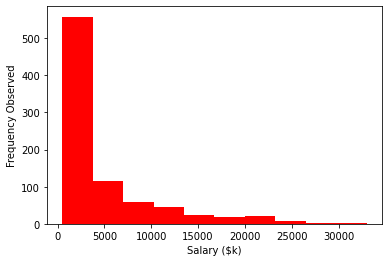

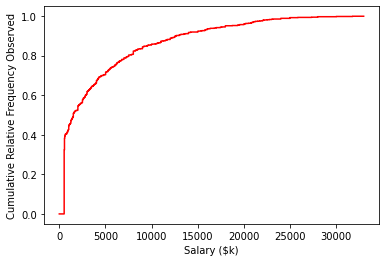

In [3]:
# observations of salaries (in $1k)
obs = df['salary']/1000

# plot histogram
plt.figure()
plt.hist(df['salary']/1000, color='r')
plt.xlabel('Salary ($k)')
plt.ylabel('Frequency Observed')
plt.show()

# compute cumulative relative frequency
x = np.linspace(0, np.max(df['salary']/1000), 1000)
F_obs = np.array([np.sum(df['salary']/1000 < i)/len(df.index) for i in x])

# plot cumulative relative frequency
plt.figure()
plt.step(x, F_obs, '-r', where='post')
plt.xlabel('Salary ($k)')
plt.ylabel('Cumulative Relative Frequency Observed')
plt.show()

## Maximum Likelihood Estimation

Maximum likelihood estimation (MLE) is a technique to determine model parameters from observed data. This section will consider three models for the distribution of baseball salaries:
 1. Normal Distribution
 2. Lognormal Distribution
 3. Pareto Distribution

### Normal Distribution

The normal distribution is characterized by two parameters: mean ($\mu$) and standard deviation ($\sigma$).

mu_0: 4396.41
sigma_0: 5900.04
LL_0: -8616.2
mu: 4396.41
sigma: 5896.58
LL: -8616.2


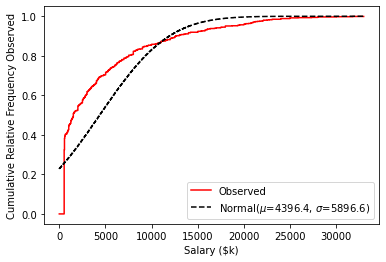

In [4]:
def minus_log_likelihood_normal(params, x):
    # note: scipy stats uses mu as the first argument and
    # sigma as the second argument for the normal distribution
    return np.sum(-np.log(stats.norm.pdf(x, params[0], params[1])))

# initial guesses for model parameters
mu_0 = np.mean(obs)
sigma_0 = np.std(obs, ddof=1)

# print initial log likelihood
print('mu_0: {:.2f}'.format(mu_0))
print('sigma_0: {:.2f}'.format(sigma_0))
print('LL_0: {:.1f}'.format(-minus_log_likelihood_normal((mu_0, sigma_0), obs)))

# minimize minus log likelihood
results = optimize.minimize(minus_log_likelihood_normal, x0=(mu_0, sigma_0), args=obs, method='Nelder-Mead')

# get optimized values from results
mu = results.x[0]
sigma = results.x[1]
LL = -results.fun

print('mu: {:.2f}'.format(mu))
print('sigma: {:.2f}'.format(sigma))
print('LL: {:.1f}'.format(LL))

# plot cumulative relative frequency
plt.figure()
plt.step(x, F_obs, '-r', where='post', label='Observed')
plt.step(x, stats.norm.cdf(x, mu, sigma), '--k', label='Normal($\mu$={:.1f}, $\sigma$={:.1f})'.format(mu, sigma))
plt.xlabel('Salary ($k)')
plt.ylabel('Cumulative Relative Frequency Observed')
plt.legend(loc='best')
plt.show()

## Lognormal Distribution

The lognormal distribution is characterized by two parameters: log mean ($\mu$) and log standard deviation ($\sigma$).

mu_0: 7.56
sigma_0: 1.30
LL_0: -7879.6
mu: 7.56
sigma: 1.30
LL: -7879.6


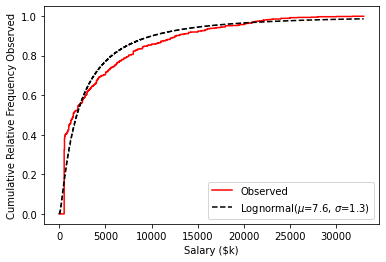

In [5]:
def minus_log_likelihood_lognormal(params, x):
    # note: scipy stats uses sigma as the first argument
    # and exp(mu) as the scale parameter for the lognormal distribution
    return np.sum(-np.log(stats.lognorm.pdf(x, params[1], scale=np.exp(params[0]))))

# initial guesses for model parameters
mu_0 = np.mean(np.log(obs))
sigma_0 = np.std(np.log(obs), ddof=1)

# print initial log likelihood
print('mu_0: {:.2f}'.format(mu_0))
print('sigma_0: {:.2f}'.format(sigma_0))
print('LL_0: {:.1f}'.format(-minus_log_likelihood_lognormal((mu_0, sigma_0), obs)))

# minimize minus log likelihood
results = optimize.minimize(minus_log_likelihood_lognormal, x0=(mu_0, sigma_0), args=obs, method='Nelder-Mead')

# get optimized values from results
mu = results.x[0]
sigma = results.x[1]
LL = -results.fun

print('mu: {:.2f}'.format(mu))
print('sigma: {:.2f}'.format(sigma))
print('LL: {:.1f}'.format(LL))

# plot cumulative relative frequency
plt.figure()
plt.step(x, F_obs, '-r', where='post', label='Observed')
plt.step(x, stats.lognorm.cdf(x, sigma, scale=np.exp(mu)), '--k', label='Lognormal($\mu$={:.1f}, $\sigma$={:.1f})'.format(mu, sigma))
plt.xlabel('Salary ($k)')
plt.ylabel('Cumulative Relative Frequency Observed')
plt.legend(loc='best')
plt.show()

## Pareto Distribution

The lognormal distribution is characterized by two parameters: shape ($\alpha$) and scale.

alpha_0: 1.000
scale_0: 507.50
LL_0: -7582.3
alpha: 0.752
scale: 507.50
LL: -7544.1


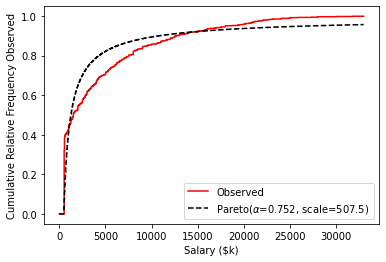

In [6]:
def minus_log_likelihood_pareto(params, x):
    # note: scipy stats uses shape (alpha) as the first argument
    # and scale as a keyword parameter for the Pareto distribution
    if np.any(x < params[1]):
        # if any observations fall below the scale parameter, return infinity
        return np.inf
    return np.sum(-np.log(stats.pareto.pdf(x, params[0], scale=params[1])))

# initial guesses for model 
alpha_0 = 1
scale_0 = np.min(obs)

# print initial log likelihood
print('alpha_0: {:.3f}'.format(alpha_0))
print('scale_0: {:.2f}'.format(scale_0))
print('LL_0: {:.1f}'.format(-minus_log_likelihood_pareto((alpha_0, scale_0), obs)))

# minimize minus log likelihood
results = optimize.minimize(minus_log_likelihood_pareto, x0=(alpha_0, scale_0), args=obs, method='Nelder-Mead')

# get optimized values from results
alpha = results.x[0]
scale = results.x[1]
LL = -results.fun

print('alpha: {:.3f}'.format(alpha))
print('scale: {:.2f}'.format(scale))
print('LL: {:.1f}'.format(LL))

# plot cumulative relative frequency
plt.figure()
plt.step(x, F_obs, '-r', where='post', label='Observed')
plt.step(x, stats.pareto.cdf(x, alpha, scale=scale), '--k', label=r'Pareto($\alpha$={:.3f}, scale={:.1f})'.format(alpha, scale))
plt.xlabel('Salary ($k)')
plt.ylabel('Cumulative Relative Frequency Observed')
plt.legend(loc='best')
plt.show()